In [1]:
library(dplyr)
library(ggplot2)
library(Seurat)
library(TFBSTools)
library(presto)
library(motifmatchr)
library(qlcMatrix)
library(scCustomize)
library(RColorBrewer)
library(ggrepel)
library(patchwork)
library(tidydr)
library(GenomicRanges)
library(Signac)
library(zoo)
library(ggpubr)
library(ComplexHeatmap)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(chromVAR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:TFBSTools’:

    Matrix


Loading required package: slam


Attaching package: ‘slam’


The following object is masked from ‘package:data.table’:

    rollup


Loading required package: sparsesvd

scCustomize v2.1.2
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.ht

# peak to gene linkage

## gene expression

In [2]:
seu <- readRDS('./03_Skin/Mskin_rna_atac_link.rds')

In [3]:
# Find DEGs bw clusters ####
DefaultAssay(seu) <- "SCT"
Idents(seu) <- seu$rna_celltype
de_genes <- FindAllMarkers(seu,only.pos = T,logfc.threshold = 0.1,max.cells.per.ident = 1000)
deg <- unique(de_genes[de_genes$p_val_adj<0.05 & de_genes$avg_log2FC>0.1,'gene'])

Calculating cluster Basal

Calculating cluster Spinous

Calculating cluster Fibroblasts

Calculating cluster Chod

Calculating cluster Dermal_papilla

Calculating cluster Cycling

Calculating cluster Vascular_endothelium

Calculating cluster Lymphatic_endothelium

Calculating cluster Muscle

Calculating cluster Melanocytes

Calculating cluster Schwann

Calculating cluster Mast_cells

Calculating cluster Mac

Calculating cluster Neural_crest

Calculating cluster Periderm



In [4]:
# gene-peak linkage
DefaultAssay(seu) <- "ATAC"
link <- Links(seu)
link <- data.frame(link)
link$adj_pval <- p.adjust(link$pvalue,method = 'BH')
link$gene_cluster <- de_genes[match(link$gene,de_genes$gene),'cluster'] # 亚群deg重叠，并添加cluster列
# cluster arrange
lvl <- levels(seu)
link <- arrange(link,factor(gene_cluster,levels=lvl))
link <- link[link$adj_pval<0.05 & link$score>0,]
# gene peak nums
t <- link %>% group_by(gene) %>% summarise(n=n())
summary(t$n) 
# write.csv(link,'./03_Skin/Mskin_link.csv')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   3.000   4.743   6.000  39.000 

In [5]:
link

,seqnames,start,end,width,strand,score,gene,peak,zscore,pvalue,adj_pval,gene_cluster
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
1,chr1,19208914,19213157,4244,*,0.05268776,Tfap2b,chr1-19213037-19213277,3.870944,5.420727e-05,9.966188e-05,Basal
2,chr1,19208914,19218357,9444,*,0.07434695,Tfap2b,chr1-19217895-19218819,2.656848,3.943750e-03,4.706237e-03,Basal
3,chr1,19208914,19222941,14028,*,0.05364106,Tfap2b,chr1-19222657-19223224,1.965515,2.467735e-02,2.556532e-02,Basal
4,chr1,19208914,19231686,22773,*,0.06125311,Tfap2b,chr1-19231381-19231990,2.500112,6.207695e-03,7.121380e-03,Basal
5,chr1,19208914,19232711,23798,*,0.07005294,Tfap2b,chr1-19232476-19232945,3.130038,8.739199e-04,1.198573e-03,Basal
6,chr1,19208914,19233947,25034,*,0.07620991,Tfap2b,chr1-19233723-19234171,3.994048,3.247738e-05,6.294311e-05,Basal
7,chr1,19208914,19256055,47142,*,0.05628334,Tfap2b,chr1-19255753-19256357,2.001405,2.267436e-02,2.361302e-02,Basal
8,chr1,19208914,19416080,207167,*,0.05625594,Tfap2b,chr1-19415748-19416412,1.951204,2.551637e-02,2.638939e-02,Basal
9,chr1,19208914,19419444,210531,*,0.07601765,Tfap2b,chr1-19418972-19419916,2.705637,3.408678e-03,4.130012e-03,Basal


---
heatmap

In [6]:
# filter score
link_processed <- link[link$score>0.1,]
link_processed <- arrange(link_processed,factor(gene_cluster,levels=lvl))

In [7]:
DefaultAssay(seu) <- "RNA"
gene.use <- unique(link$gene)
# cellcyclescore
cc.genes
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seu <- CellCycleScoring(seu, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE) 
seu <- ScaleData(seu,vars.to.regress = c("S.Score", "G2M.Score"),features=gene.use)
rna <- seu@assays$RNA@scale.data[gene.use,]
asplit_cells <- split(colnames(seu), seu$rna_celltype)
n <- 10
means <- do.call(cbind, lapply(lvl, function(x){
        df <- rna[,asplit_cells[[x]]]
        t(apply(df,1,function(x){rollapply(x,n,mean,by=n)}))
}))
celltype_major <- unlist(lapply(lvl, function(x) rep(x, length(asplit_cells[[x]])%/%n)))

$s.genes
 [1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"    

$g2m.genes
 [1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

Warning message:
"The following features are not present in the object: MCM5, PCNA, TYMS, FEN1, MCM2, MCM4, RRM1, UNG, GINS2, MCM6, CDCA7, DTL, PRIM1, UHRF1, MLF1IP, HELLS, RFC2, RPA2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, MSH2, ATAD2, RAD51, RRM2, CDC45, CDC6, EXO1, TIPIN, DSCC1, BLM, CASP8AP2, USP1, CLSPN, POLA1, CHAF1B, BRIP1, E2F8, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: HMGB2, CDK1, NUSAP1, UBE2C, BIRC5, TPX2, TOP2A, NDC80, CKS2, NUF2, CKS1B, MKI67, TMPO, CENPF, TACC3, FAM64A, SMC4, CCNB2, CKAP2L, CKAP2, AURKB, BUB1, KIF11, ANP32E, TUBB4B, GTSE1, KIF20B, HJURP, CDCA3, HN1, CDC20, TTK, CDC25C, KIF2C, RANGAP1, NCAPD2, DLGAP5, CDCA2, CDCA8, ECT2, KIF23, HMMR, AURKA, PSRC1, ANLN, LBR, CKAP5, CENPE, CTCF, NEK2, G2E3, GAS2L3, CBX5, CENPA, not searching for symbol synonyms"
Warning message in AddModuleScore(object = object, features = features, name = name, :
"Could not find enough features in the object 

In [8]:
anno_col <- data.frame(celltype_major)
rownames(anno_col) <- colnames(means) <- paste0(seq(1:ncol(means)),colnames(means))
# 
lvl <- c('Basal','Spinous','Fibroblasts','Chod','Dermal_papilla','Cycling','Vascular_endothelium','Lymphatic_endothelium','Muscle','Melanocytes','Schwann','Mast_cells','Mac','Neural_crest','Periderm')
anno_col <- arrange(anno_col,factor(celltype_major,levels=lvl))
anno_col$celltype_major <- factor(anno_col$celltype_major,levels=lvl)

In [9]:
genes <- c("Krt5",'Col17a1','Krt15','Krt1','Krt10','Col1a1','Pdgfra','Lum','Dcn','Col1a2','Sox9','Col2a1','Col9a3','Acan','Bmp7','Hhip','Apcdd1','Mki67','Top2a','pecam1','Cdh5','Flt4',
           'Lyve1','Prox1','Tagln','Acta2','Rgs5','Mitf','Sox10','Mlana','Pax3','Itgb8','Scn7a','Plp1','Kit','Tpsb2','Cpa3','Il1rl1','Cd14','Cd163','C1qb','Itgax','Ppp1r1c','Syt13','Ptprr','Pcbp3','Myn14','Krt17','Grhl3')
genes_t <- c("Krt5",'Col17a1','Krt15','Krt1','Krt10','Col1a1','Lum','Col1a2','Col2a1','Col9a3','Acan','Cdh5','Flt4',
           'Lyve1','Prox1','Rgs5','Mitf','Sox10','Pax3','Itgb8','Scn7a','Kit','Tpsb2','Cpa3','Il1rl1','C1qb','Krt17','Grhl3')
genes <- as.data.frame(genes_t)
# annotate genes
first_occurrence <- sapply(genes$genes_t, function(x) which(rownames(means) == x)[1])
first_occurrence
# colnames(means) <- anno_col$celltype_major
# write.csv(means,'./03_Skin/Mskin_heatmap.csv')

Krt5 Col17a1   Krt15    Krt1   Krt10  Col1a1     Lum  Col1a2  Col2a1  Col9a3 
    349     401     285     694     640     985     961     866    1276    1143 
   Acan    Cdh5    Flt4   Lyve1   Prox1    Rgs5    Mitf   Sox10    Pax3   Itgb8 
   1207    1794    1844    2014    1467    2044    2136    2160    2110    1579 
  Scn7a     Kit   Tpsb2    Cpa3  Il1rl1    C1qb   Krt17   Grhl3 
   2178    2131    2724    2324    2251    2819     283     104

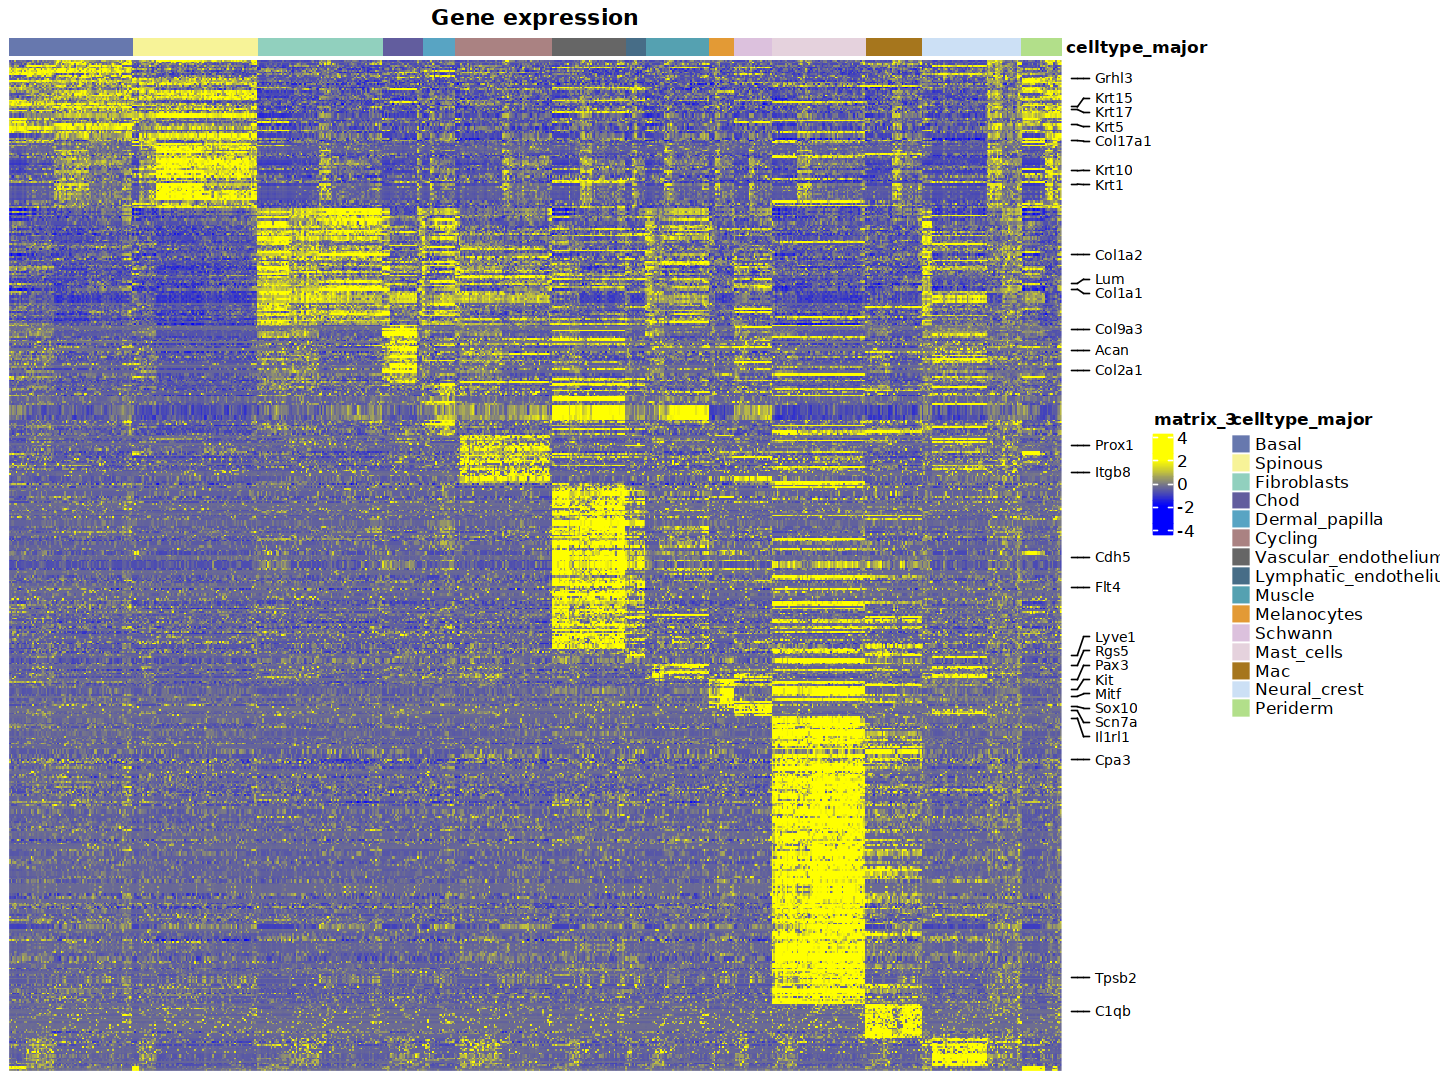

In [10]:
options(repr.plot.width = 12, repr.plot.height = 9)
# yellow2blue = colorRampPalette(colors = c("blue","black","yellow"))(100)
BluYl = colorRampPalette(colors = c("blue","yellow"))(100)
label_colors <- list(celltype_major=c('Fibroblasts' = '#91D0BE','Dermal_papilla' = '#58A4C3','Periderm' = '#B2DF8A','Basal' = '#6778AE',
  'Spinous' = '#F7F398','Neural_crest' = '#CCE0F5','Melanocytes' = '#E39A35','Schwann' = '#DCC1DD','Mast_cells' = '#E5D2DD','Mac' = '#A6761D',
  'Vascular_endothelium' = '#666666','Lymphatic_endothelium' = '#476D87','Muscle' = '#55A1B1','Cycling' = '#aa8282','Chod' = '#625D9E'))
p1 = pheatmap(means[link_processed$gene,rownames(anno_col)], cluster_rows = F, cluster_cols = F, scale = "row", show_rownames = F,
         breaks = seq(-2, 2, length = 101), col = BluYl,
         annotation_col = anno_col,show_colnames = F, annotation_colors = label_colors, use_raster = TRUE,
         main='Gene expression') + rowAnnotation(link = anno_mark(at = first_occurrence, labels = genes$genes_t, labels_gp = gpar(fontsize = 8))) #filename ="./03_Skin/peak_gene_linkages_gene.pdf",width=10,height=6
p1
# pdf('./03_Skin/peak_gene_linkages_gene.pdf',width=12,height=9)
# p1
# dev.off()

## chromatin accessibility 

In [11]:
peak.use <- unique(link$peak)
DefaultAssay(seu) <- "ATAC"
Idents(seu) <- 'rna_celltype'
atac <- RunTFIDF(seu@assays$ATAC@counts[peak.use,])
asplit_cells <- split(colnames(seu), seu$rna_celltype)
means_peak <- do.call(cbind, lapply(lvl, function(x){
        df <- atac[,asplit_cells[[x]]]
        t(apply(df,1,function(x){rollapply(x,n,mean,by=n)}))
}))

Performing TF-IDF normalization



In [12]:
celltype_major <- unlist(lapply(lvl, function(x) rep(x, length(asplit_cells[[x]])%/%n)))
anno_col2 <- data.frame(celltype_major)
rownames(anno_col2) <- colnames(means_peak) <- paste0(seq(1:ncol(means_peak)),colnames(means_peak))
anno_col2$celltype_major <- factor(anno_col2$celltype_major,levels=lvl)
anno_col2 <- arrange(anno_col2,factor(celltype_major,levels=lvl))

In [13]:
options(repr.plot.width = 12, repr.plot.height = 9)
p2 = pheatmap(means_peak[link_processed$peak,rownames(anno_col2)],cluster_rows = F, cluster_cols = F, scale = "row", show_rownames = F,
               breaks = seq(-2, 2, length = 101), color = hcl.colors(100, "BluYl"),
               annotation_col = anno_col, show_colnames = F, annotation_colors = label_colors, use_raster=TRUE,
               main='Chromatin accessibility') + rowAnnotation(link = anno_mark(at = first_occurrence, labels = genes$genes_t, labels_gp = gpar(fontsize = 8)))
# pdf('./03_Skin/peak_gene_linkages_peak.pdf',width=12,height=9)
# p2
# dev.off()

Warning message:
"It not suggested to both set `scale` and `breaks`. It makes the
function confused."
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



In [14]:
# all linkage / involved gene / involved peak
dim(link)
length(unique(link$gene))
length(unique(link$peak))

[1] 15016    12

[1] 3166

[1] 12687

## Coverage plot

In [15]:
Idents(seu) <- 'rna_celltype'
DefaultAssay(seu) <- 'ATAC'
#fig3A&B  umap #fig3B umap #RNA label trasfer to atac
cluster_cols = c('#6778AE','#F7F398','#91D0BE','#B2DF8A','#58A4C3',   '#aa8282','#666666','#476D87','#55A1B1','#E39A35','#DCC1DD','#E5D2DD','#A6761D','#CCE0F5','#BEAED4')
options(repr.plot.width=14, repr.plot.height=14)
cov_plot <- CoveragePlot(object = seu,region = "chr11-100250000-100266000", features = "Krt17", annotation = TRUE, peaks = TRUE, links = TRUE)  & scale_fill_manual(values = cluster_cols) 
# cov_plot
# region = "chr5-75135000-75250000", features = "Pdgfra"
# region = "chr15-101840000-101856000", features = "Krt1"
# region = "chr11-99381000-99394000", features = "Krt10"
# region = "chr11-100250000-100266000", features = "Krt17"
#
# region = "chr1-91750000-91900000", features = "Twist2"
# region = "chr15-101700000-101720000", features = "Krt5"
# region = "chr19-47640000-47700000", features = "Col17a1"
# region = "chr11-103760000-103835000", features = "Wnt3"
# region = "chr11-100130000-100139000", features = "Krt15"
# region = "chr18-43940000-44040000", features = "Spink5"
# ggsave("./03_Skin/Mskin_cov_plot_Krt17.pdf",cov_plot,width=14,height=14)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
"Removed 3 rows containing missing values or values outside the scale range (`geom_segment()`)."


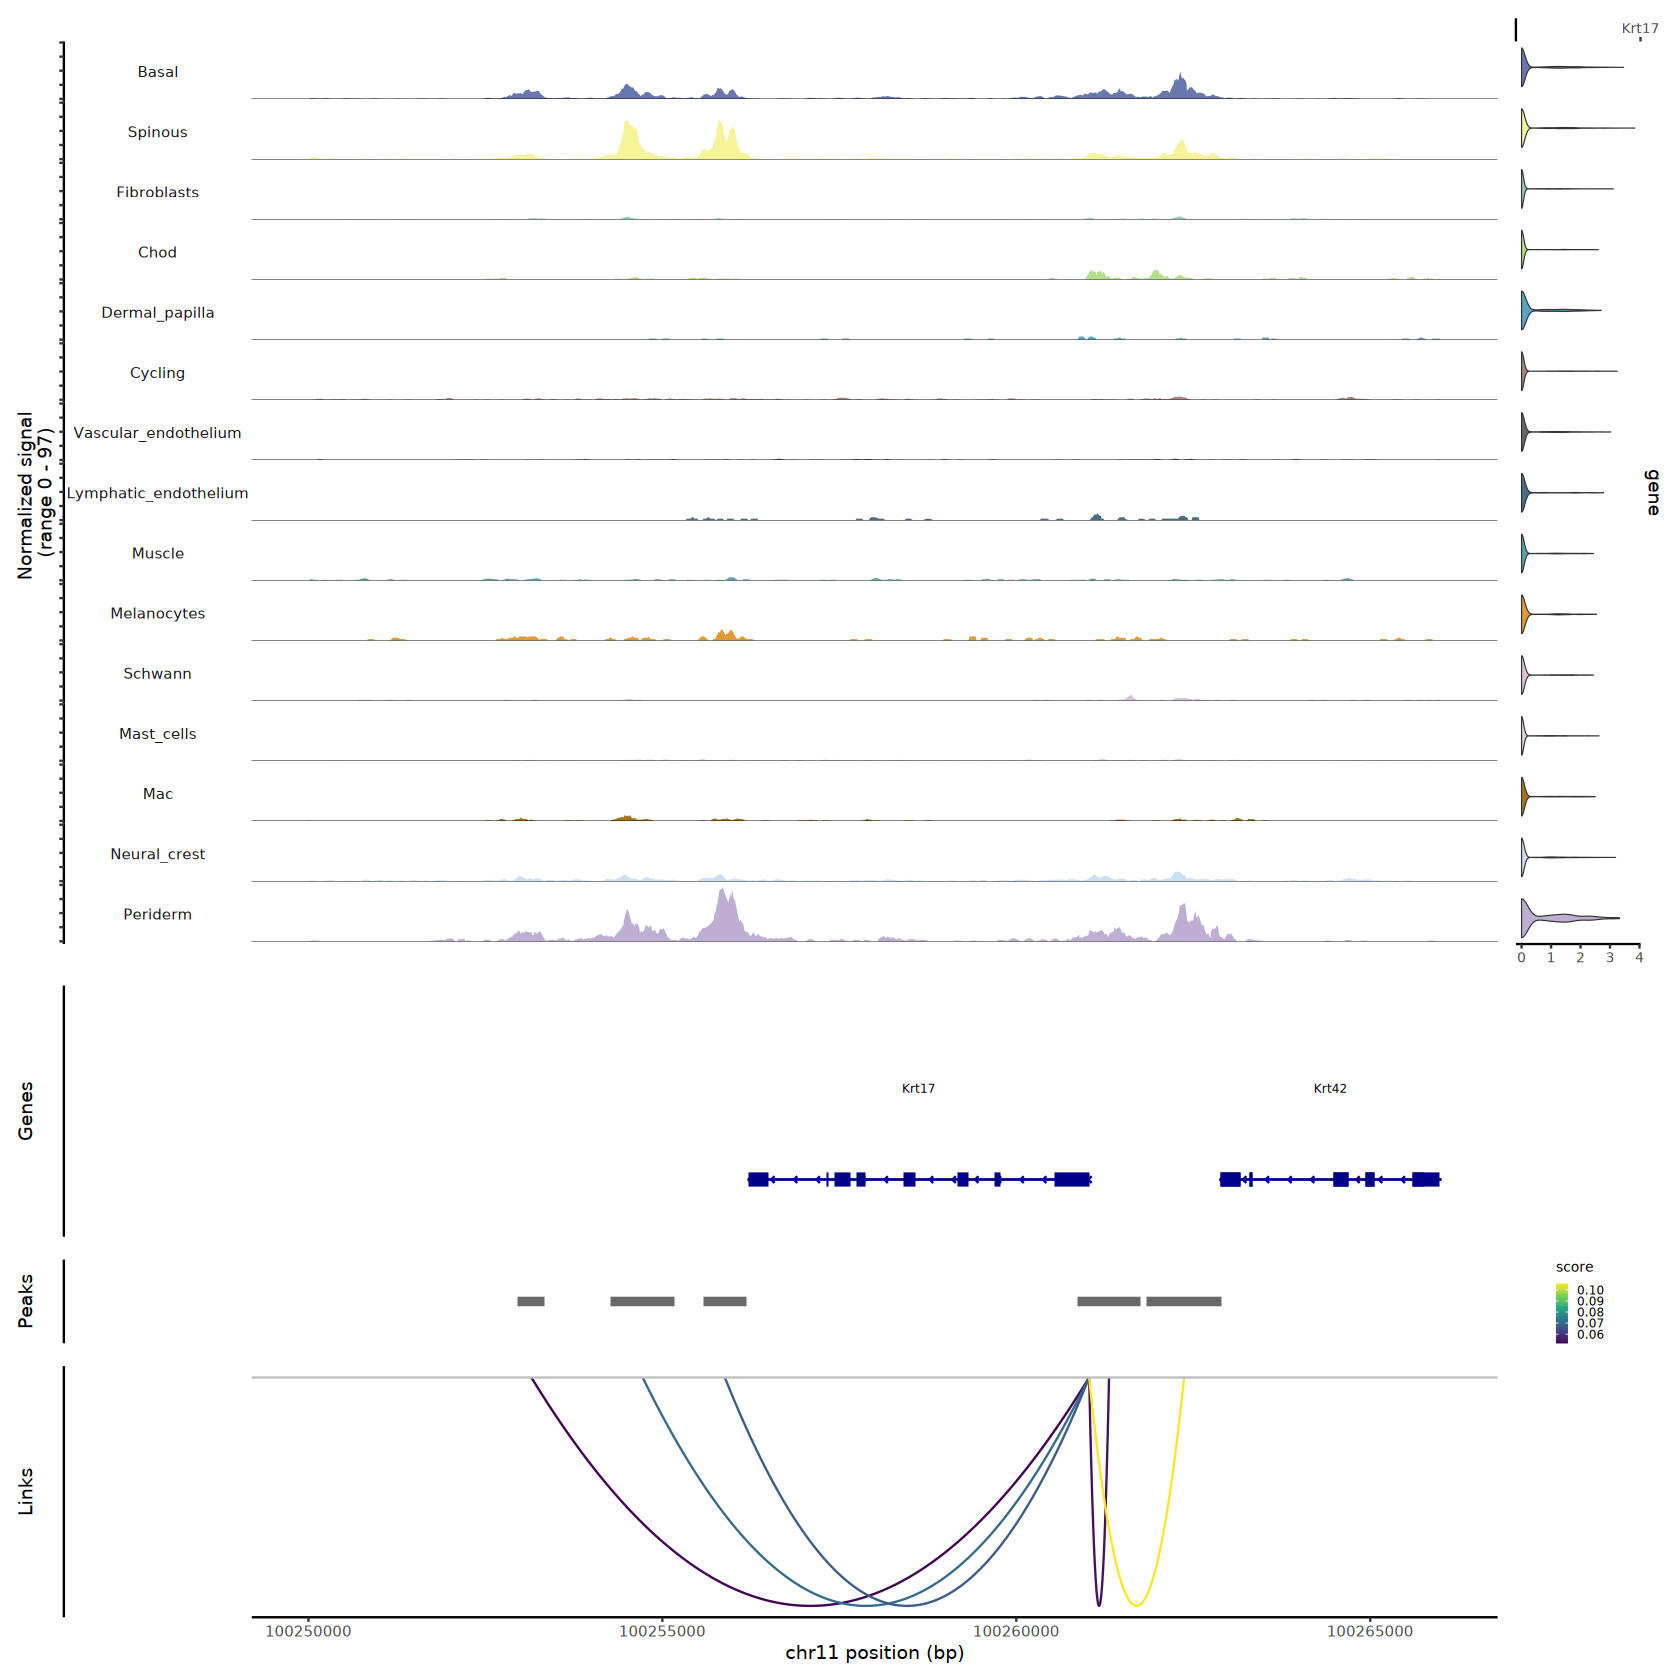

In [16]:
options(repr.plot.width=14, repr.plot.height=14)
library(viridis)
Idents(seu) <- 'rna_celltype'
DefaultAssay(seu) <- 'ATAC'
cluster_cols = c('#6778AE','#F7F398','#91D0BE','#B2DF8A','#58A4C3','#aa8282','#666666','#476D87','#55A1B1','#E39A35','#DCC1DD','#E5D2DD','#A6761D','#CCE0F5','#BEAED4')
feature = "Krt17"
region ="chr11-100250000-100266000"
p <- CoveragePlot(object = seu,region = region, features = feature, annotation = TRUE, peaks = TRUE, links = TRUE,scale.linewidth = TRUE)  & scale_fill_manual(values = cluster_cols) 
linkplot <- p[[1]][[3]][[3]]
p[[1]][[3]][[3]] <- linkplot + scale_color_viridis_c()# scale_color_gradient(low = "#ffffbf", high = "#d7191c") #limits = c(- 10, 200)scale_colour_brewer('Blues')'#C8F5FF','#01576A'
p3=p
p3
# ggsave("./03_Skin/Mskin_cov_plot_Pdgfra.pdf",p,width=14,height=14)

## Correlation Plot

In [18]:
# 
tmp <- link_processed[link_processed$gene_cluster=="Fibrobalsts",]
gene <- "Pdgfra"
tmp <- na.omit(tmp[tmp$gene==gene,])
tmp <- arrange(tmp,-score)
peak1 <- tmp$peak[1]
region <- unlist(lapply(tmp[,'peak'],function(x){as.numeric(strsplit(x,"-",fixed=T)[[1]][c(2,3)])}))
peak2 <- paste(strsplit(tmp[1,'peak'],"-",fixed=T)[[1]][1],
             min(region,na.rm = T),
             max(region,na.rm=T),sep="-")

Warning message in min(region, na.rm = T):
"no non-missing arguments to min; returning Inf"
Warning message in max(region, na.rm = T):
"no non-missing arguments to max; returning -Inf"


In [18]:
gene <- "Pdgfra"
tmp <- na.omit(link[link$gene==gene,])
tmp <- arrange(tmp,-score)
peak1 <- tmp$peak[1]
region <- unlist(lapply(tmp[,'peak'],function(x){as.numeric(strsplit(x,"-",fixed=T)[[1]][c(2,3)])}))
peak2 <- paste(strsplit(tmp[1,'peak'],"-",fixed=T)[[1]][1],
             min(region,na.rm = T),
             max(region,na.rm=T),sep="-")

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


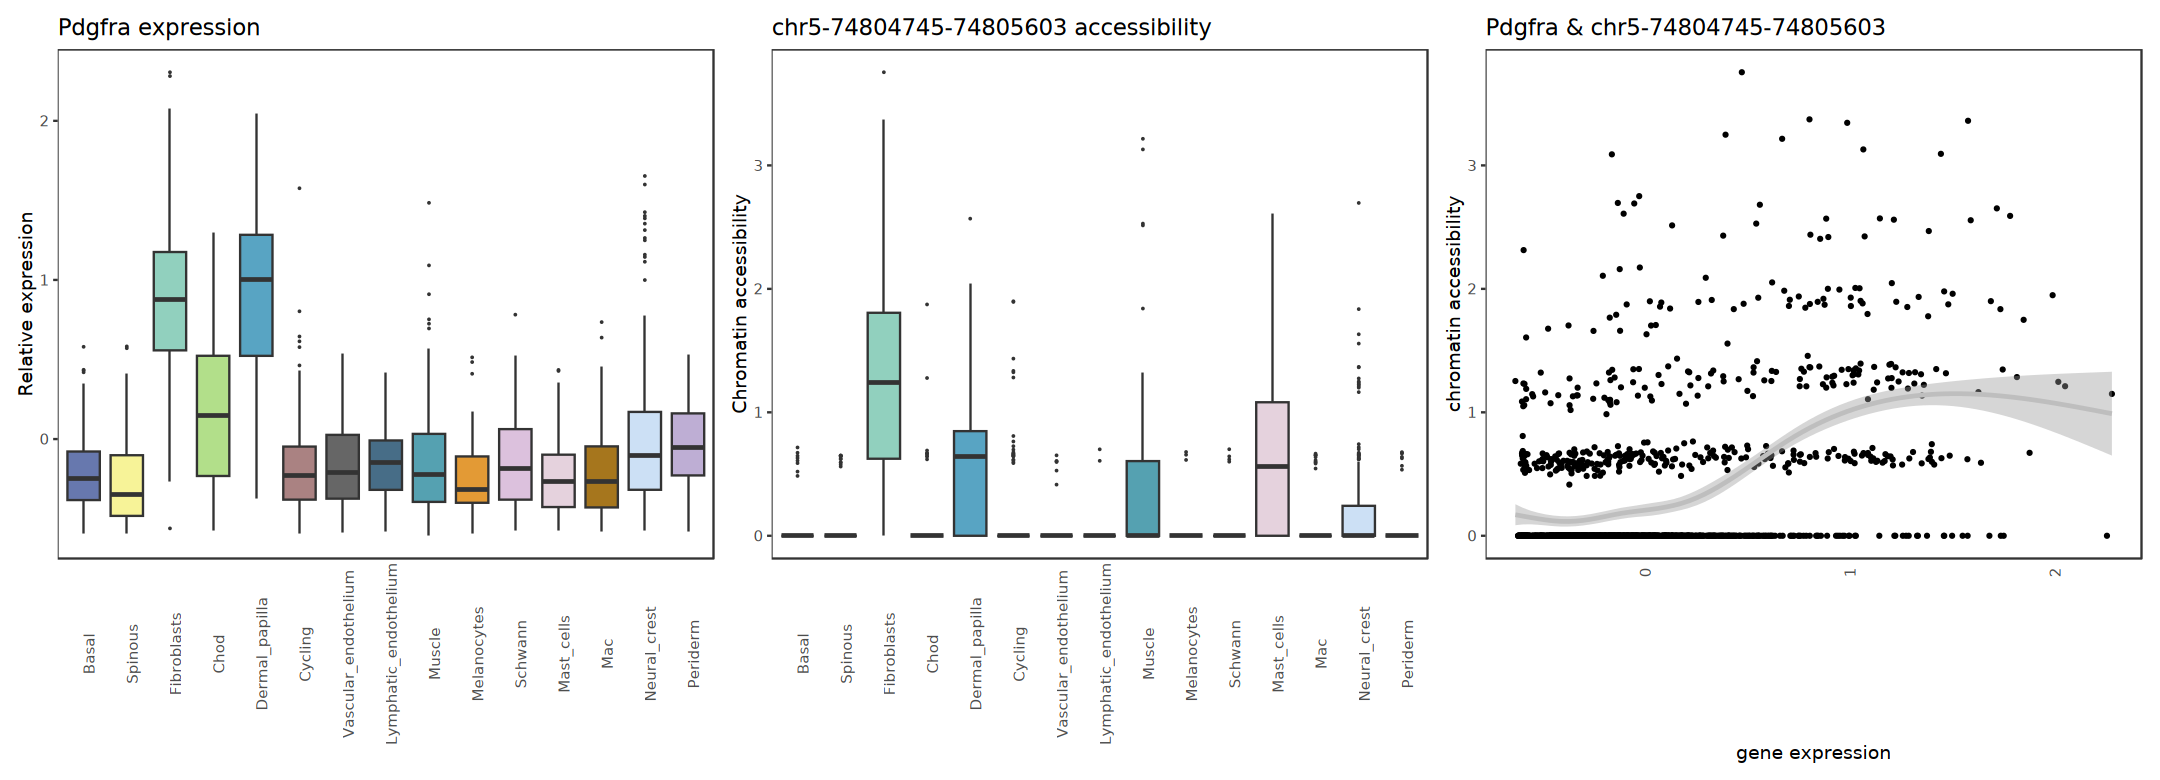

In [19]:
options(repr.plot.width = 18, repr.plot.height = 6.5)
cluster_cols = c('#6778AE','#F7F398','#91D0BE','#B2DF8A','#58A4C3',   '#aa8282','#666666','#476D87','#55A1B1','#E39A35','#DCC1DD','#E5D2DD','#A6761D','#CCE0F5','#BEAED4')
df <- data.frame(gene_expr=means[gene,],celltype=anno_col$celltype_major)
p1 <- ggplot(df,aes(celltype,gene_expr,fill=celltype))+ geom_boxplot(outlier.size = 0.01) + scale_fill_manual(values=cluster_cols)+ 
        theme_bw()+ggtitle(paste0(gene, " expression"))+ xlab("")+ylab("Relative expression")+
        theme(axis.text.x = element_text(angle=90),axis.ticks.x=element_blank(),legend.position='none',panel.grid.major = element_blank(),panel.grid.minor = element_blank()) 
df <- data.frame(atac=means_peak[peak1,],celltype=anno_col2$celltype_major)
p2 <- ggplot(df,aes(celltype,atac,fill=celltype)) + geom_boxplot(outlier.size = 0.01) + scale_fill_manual(values=cluster_cols)+ 
        theme_bw()+ggtitle(paste0(peak1, " accessibility"))+ xlab("")+ylab("Chromatin accessibility")+
        theme(axis.text.x = element_text(angle=90),axis.ticks.x=element_blank(),legend.position='none',panel.grid.major = element_blank(),panel.grid.minor = element_blank()) 
df <- data.frame(gene_expr=means[gene,],atac=means_peak[peak1,])
p3 <- ggplot(df,aes(gene_expr,atac))+geom_point(size = 0.7)+geom_smooth(color="grey")+ 
        theme_bw()+ggtitle(paste0(gene, " & ", peak1))+xlab("gene expression")+ylab("chromatin accessibility")+
        theme(axis.text.x = element_text(angle=90),axis.ticks.x=element_blank(),legend.position='none',panel.grid.major = element_blank(),panel.grid.minor = element_blank()) 
p1|p2|p3
ggsave('./03_Skin/correlation_plot_Pdgfra.pdf',p1|p2|p3,width=18,height=6.5)